<a href="https://colab.research.google.com/github/enakai00/colab_GenAI_lecture/blob/main/15_Transformer_emotion_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

In [3]:
from datasets import load_dataset
emotions = load_dataset('emotion')

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

VOCAB_SIZE

30522

In [5]:
text_length = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=text_length,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=text_length,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

In [7]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def call(self, x):
        seq_len = tf.shape(x)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        x = self.token_emb(x)
        x = x + position_embeddings
        x = self.ln(x)
        x = self.dropout(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, masks):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        attention_mask = tf.reshape(
            tf.tile(masks, [1, seq_len]), [batch_size, seq_len, seq_len])
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=attention_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output) # Skip connection
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores) # Skip connection

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [8]:
MAX_LEN = 128
EMBEDDING_DIM = 512
N_HEADS = 8
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32)
mask_inputs = layers.Input(shape=(None,), dtype=tf.int32)

x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(text_inputs)
x, _ = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
x, _ = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x, mask_inputs)
output = layers.Dense(6, activation='softmax')(x[:, 0, :]) # select [CLS] token

transformer_model = models.Model(inputs=[text_inputs, mask_inputs],
                                 outputs=output)

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 512)   15693824    ['input_1[0][0]']                
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 transformer_block (Transformer  ((None, None, 512),  3152384    ['token_and_position_embeddin

In [9]:
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                          loss='categorical_crossentropy',
                          metrics=['acc'])

In [10]:
%%time
history = transformer_model.fit([train_text, train_mask], train_label,
                                 validation_data=([test_text, test_mask], test_label),
                                 batch_size=32, epochs=8)

Epoch 1/8
500/500 [==============================] - 83s 129ms/step - loss: 1.7004 - acc: 0.3162 - val_loss: 1.5034 - val_acc: 0.4155
Epoch 2/8
500/500 [==============================] - 43s 87ms/step - loss: 0.9328 - acc: 0.6746 - val_loss: 0.3936 - val_acc: 0.8755
Epoch 3/8
500/500 [==============================] - 35s 71ms/step - loss: 0.4271 - acc: 0.8550 - val_loss: 0.2989 - val_acc: 0.8910
Epoch 4/8
500/500 [==============================] - 36s 72ms/step - loss: 0.3259 - acc: 0.8853 - val_loss: 0.2534 - val_acc: 0.8990
Epoch 5/8
500/500 [==============================] - 38s 75ms/step - loss: 0.2764 - acc: 0.8974 - val_loss: 0.2553 - val_acc: 0.9010
Epoch 6/8
500/500 [==============================] - 35s 70ms/step - loss: 0.2372 - acc: 0.9096 - val_loss: 0.2531 - val_acc: 0.8980
Epoch 7/8
500/500 [==============================] - 37s 74ms/step - loss: 0.2170 - acc: 0.9146 - val_loss: 0.2489 - val_acc: 0.9055
Epoch 8/8
500/500 [==============================] - 37s 74ms/step -

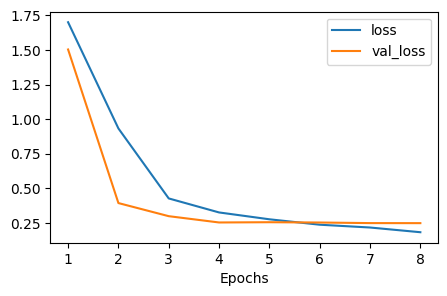

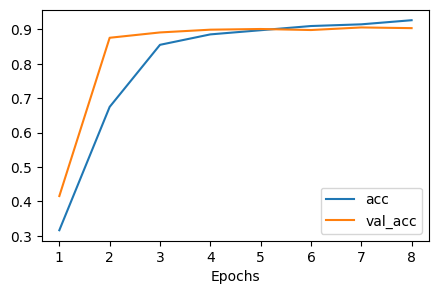

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

In [12]:
predictions = transformer_model.predict([test_text, test_mask], verbose=0)

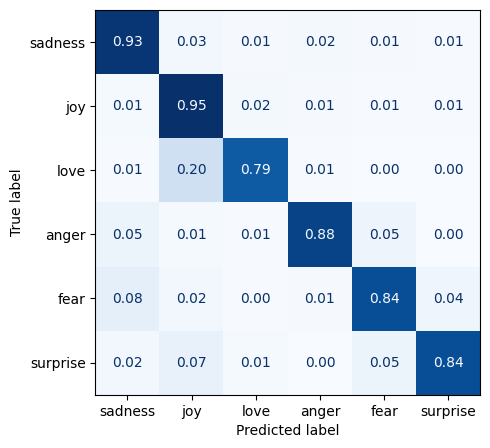

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

In [14]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=len(train_text[0]),
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

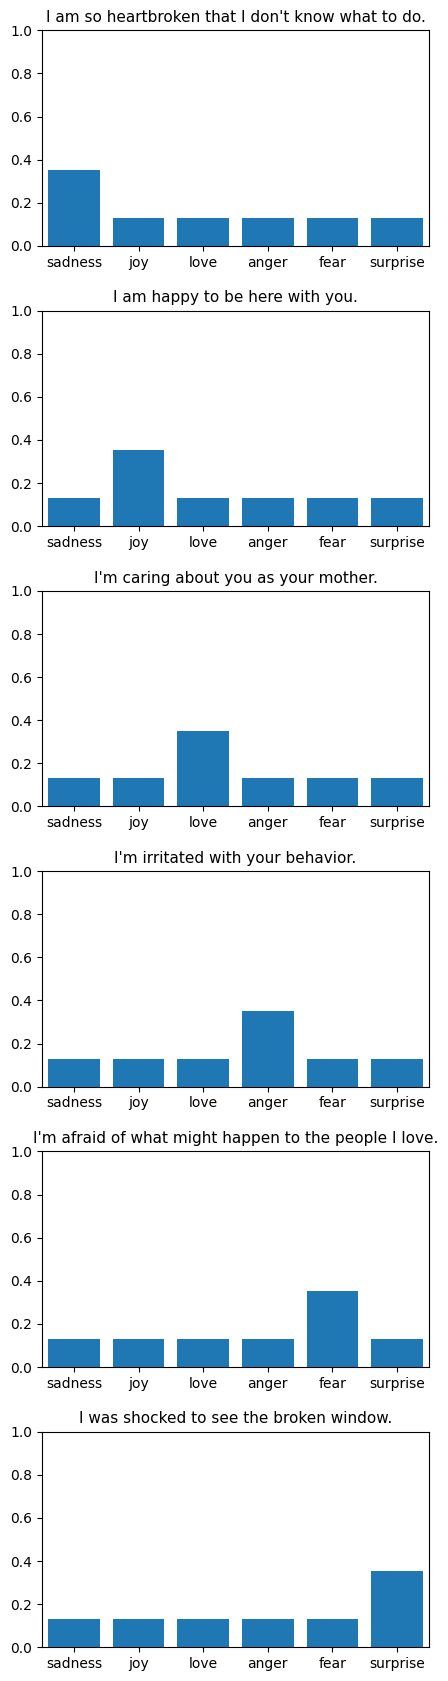

In [15]:
n = len(predictions)
fig = plt.figure(figsize=(5, 3.5 * n))
plt.subplots_adjust(hspace=0.3)

for c, pred in enumerate(predictions):
    probs = np.exp(pred)/sum(np.exp(pred))
    subplot = fig.add_subplot(n, 1, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), probs, align='center')